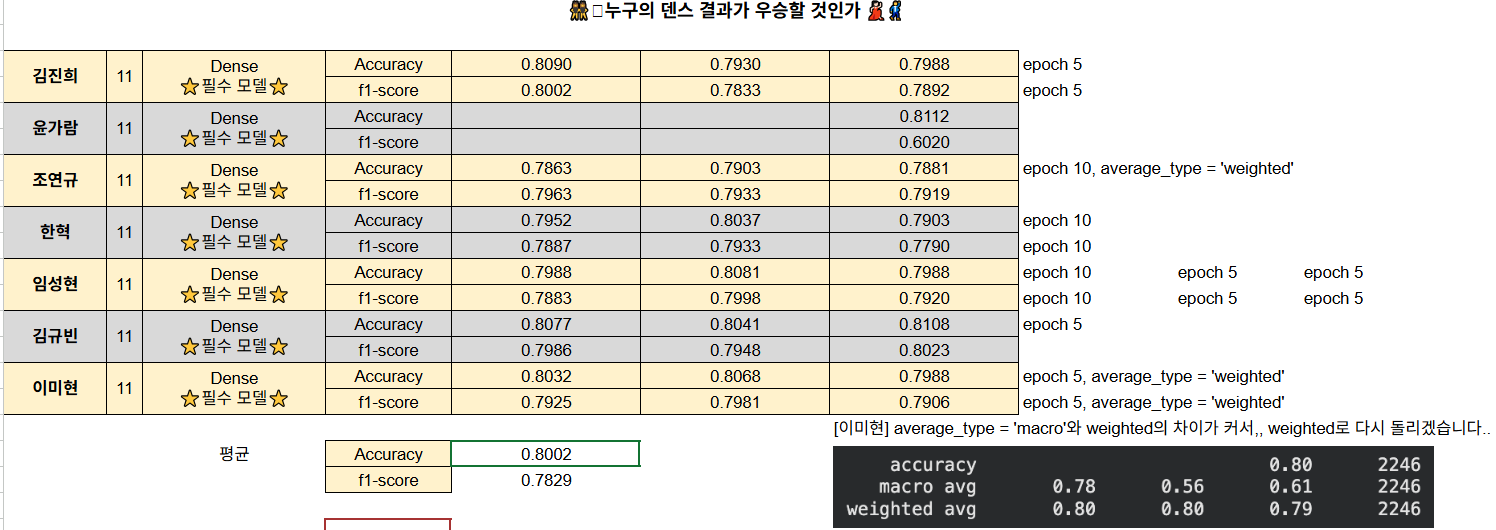

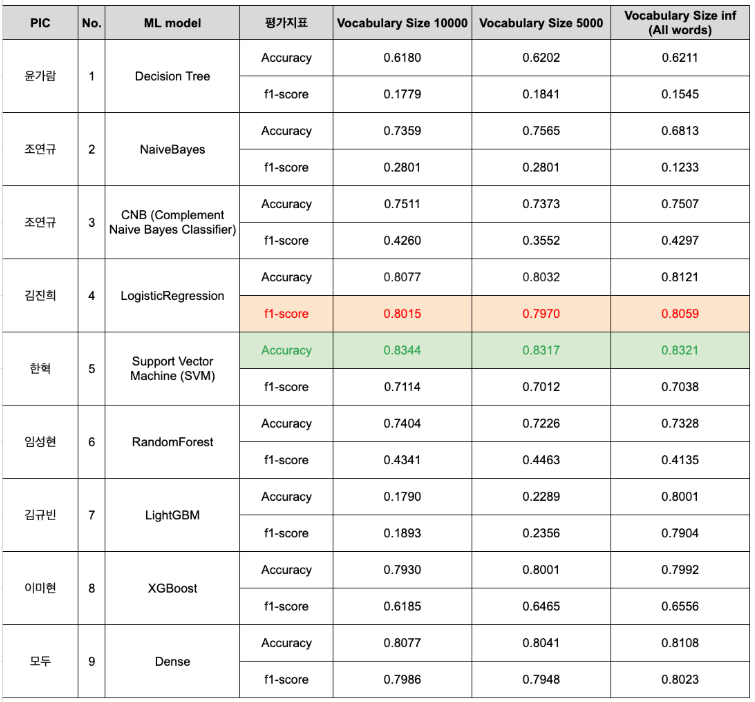

기본 Dense model의 성능은 acc: 0.8 , f1: 0.78 정도로 확인했다.

# 실험 결과 요약

- 정확도가 가장 좋은 모델은 svm 이었다. (기본 dense모델보다 개선)
- f1 score는 좋은 모델은 Linear Regression이었다. (기본 dense모델과 비슷)
- svm 모델 훈련을 맡아서 진행하였고, 모델에 weighted 옵션을 부여해서, 클래스 불균형을 해결하였다. weighted옵션이 없을때보다 정확도와 f1 score가 2% ~ 3%정도 개선되었다.
- LightGBM (성능 대폭향상), 나이브베이즈 (성능하락) 외에는 word의 갯수가 유의미한 차이가 없었다.




# 회고

- 기존 dense모델을 조금더 개선할수 있는 방법 (weighted 적용하기)
- 시도해본 결과 가장 성능이 좋다.
  - acc: 0.8228
  - f1-score: 0.8228
- 학습시간은 10분으로 단축되었다. (batch size를 256으로 키워서 진행, 기존 학습시간 25분)

#오늘 할일
### 실험 또 실험 🤯


1. 단어장 개수를 바꾸면서(10000, 5000, Nan) 8개의 ML모델을 사용해보고  accuacry와 f1-score를 비교
(표로 나타내보세요~) (벡터화는 tf-idf로 통일)

2. 딥러닝과 머신런닝의 차이 비교하기
- 딥러닝 모델 1개 Dense를 이용해서 비교해보세요 평가지표 = accuacry, f1-score

In [6]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 데이터 준비
## index -> text
## DTM , TF-idf 학습데이터 준비

In [7]:
# 이부분에있는 num_words를 5000과 다른방법으로 바꿔보세요~

# (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
# (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [10]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [11]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


In [12]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [13]:
x_train_tfidf.shape

(8982, 9670)

In [14]:
x_test_tfidf.shape

(2246, 9670)

In [26]:
x_train[3]

"<sos> the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely <unk> borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in <unk> financial eligibility standards indicated as many as one half of <unk> borrowers who received new loans from the agency in 1986 would be <unk> under the proposed system the agency has proposed evaluating <unk> credit using a variety of financial ratios instead of relying solely on <unk> ability senate agriculture committee chairman patrick leahy d vt <unk> the proposed eligibility changes telling <unk> administrator <unk> clark at a hearing that they would mark a dramatic shift in the agency's purpose away from being farmers' lender of last re

# 모델 정의 및 실험 (SVM)

여러가지 모델을 바꾸며 실험해보세요~

In [11]:
# TF-idf데이터로 XGBoost 모델 학습하기

from sklearn.svm import LinearSVC

# SVM 모델 학습
svm_model = LinearSVC(C=1.0, max_iter=3000, class_weight = 'balanced', random_state=0)
svm_model.fit(x_train_tfidf, y_train)

LinearSVC(class_weight='balanced', max_iter=3000, random_state=0)

In [12]:
# 예측
y_pred = svm_model.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.8317
✅ F1-score : 0.7012


# Dense NN 딥러닝 모델

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Dense, Dropout


# 아래 Dense의 레이어를 바꿔가며 성능을 확인해봅시다

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# 샘플 하나의 shape: (26506,)
inputs = Input(shape=(9670,))

x = Dense(512, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(46, activation='softmax')(x)  # 클래스 46개

dense_model = Model(inputs=inputs, outputs=outputs)

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9670)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,951,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,023,150 (19.16 MB)

 Trainable params: 5,023,150 (19.16 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# 시간이 좀 걸립니다! 한 20분정도..
dense_model.fit(x_train_tfidf, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.5028 - loss: 2.2587 - val_accuracy: 0.7451 - val_loss: 1.0915
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7996 - loss: 0.8842 - val_accuracy: 0.8041 - val_loss: 0.8681
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.8883 - loss: 0.4802 - val_accuracy: 0.8097 - val_loss: 0.8462
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 172s 761ms/step - accuracy: 0.9344 - loss: 0.2660 - val_accuracy: 0.8152 - val_loss: 0.8582
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 163s 726ms/step - accuracy: 0.9484 - loss: 0.1985 - val_accuracy: 0.8225 - val_loss: 0.8778
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 120s 534ms/step - accuracy: 0.9607 - loss: 0.1468 - val_accuracy: 0.8147 - val_loss: 0.8852
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 137s 612ms/step - accuracy: 0.9596 - loss: 0.1359 - val_accuracy: 0.8136 - val_loss: 0.9325
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 93s 416ms/step - accuracy: 0.9673 - loss: 0.1

In [15]:


y_pred_proba = dense_model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step
✅ Accuracy: 0.8037
✅ F1-score: 0.7933


# Dense모델 커스터마이징

## dense 클래스 불균형 해결방법 (class_weight 적용)

기초모델에서 num_words가 10000이 가장 좋았었으므로, 10000을 기준으로 하겠음.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Dense, Dropout


# 아래 Dense의 레이어를 바꿔가며 성능을 확인해봅시다

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# 샘플 하나의 shape: (26506,)
inputs = Input(shape=(9670,))

x = Dense(512, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(46, activation='softmax')(x)  # 클래스 46개

dense_model = Model(inputs=inputs, outputs=outputs)

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9670)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,951,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 46)             │         5,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,023,150 (19.16 MB)

 Trainable params: 5,023,150 (19.16 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# 1. 클래스별 가중치 계산 (희귀 클래스는 높은 가중치, 빈출 클래스는 낮은 가중치)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# 2. Keras 모델에 넣기 위해 딕셔너리 형태로 변환 {0: 1.5, 1: 0.5 ...}
class_weight_dict = dict(enumerate(class_weights))

# 3. 조기 종료(Early Stopping) 설정 (시간 단축용)
# 검증 손실(val_loss)이 3번 연속으로 좋아지지 않으면 학습을 멈춥니다.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# 4. 모델 학습 시 class_weight 파라미터 전달
history = dense_model.fit(
    x_train_tfidf,
    y_train,
    epochs=10,
    batch_size=256, # batch 사이즈 증가. 32 -> 256
    validation_split=0.2,
    callbacks=[es],         # 조기 종료 콜백 추가
    class_weight=class_weight_dict
)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.1719 - loss: 3.7994 - val_accuracy: 0.6784 - val_loss: 3.5568
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.6864 - loss: 3.3339 - val_accuracy: 0.7535 - val_loss: 2.6804
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7371 - loss: 2.7452 - val_accuracy: 0.7607 - val_loss: 1.7871
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.7785 - loss: 1.7745 - val_accuracy: 0.7691 - val_loss: 1.3579
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8214 - loss: 0.9481 - val_accuracy: 0.7796 - val_loss: 1.1531
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8309 - loss: 0.5975 - val_accuracy: 0.7930 - val_loss: 1.0295
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8611 - loss: 0.4101 - val_accuracy: 0.8002 - val_loss: 0.9643
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8864 - loss: 0.2839 - val_accuracy: 0.8008 - val_loss:

In [17]:
# 평가
y_pred_proba = dense_model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step
✅ Accuracy: 0.8228
✅ F1-score: 0.8228


## 2차시도 (batch 128)

In [18]:
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# 1. 클래스별 가중치 계산 (희귀 클래스는 높은 가중치, 빈출 클래스는 낮은 가중치)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# 2. Keras 모델에 넣기 위해 딕셔너리 형태로 변환 {0: 1.5, 1: 0.5 ...}
class_weight_dict = dict(enumerate(class_weights))

# 3. 조기 종료(Early Stopping) 설정 (시간 단축용)
# 검증 손실(val_loss)이 3번 연속으로 좋아지지 않으면 학습을 멈춥니다.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# 4. 모델 학습 시 class_weight 파라미터 전달
history = dense_model.fit(
    x_train_tfidf,
    y_train,
    epochs=10,
    batch_size=128, # batch 사이즈 증가. 32 -> 256
    validation_split=0.2,
    callbacks=[es],         # 조기 종료 콜백 추가
    class_weight=class_weight_dict
)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9151 - loss: 0.1583 - val_accuracy: 0.8203 - val_loss: 0.8450
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9327 - loss: 0.1260 - val_accuracy: 0.8236 - val_loss: 0.8352
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9416 - loss: 0.1024 - val_accuracy: 0.8175 - val_loss: 0.8685
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9444 - loss: 0.0909 - val_accuracy: 0.8147 - val_loss: 0.8861
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9448 - loss: 0.0961 - val_accuracy: 0.8180 - val_loss: 0.8792
Epoch 5: early stopping


In [19]:
# 평가
y_pred_proba = dense_model.predict(x_test_tfidf)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Accuracy: 0.8130
✅ F1-score: 0.8103
